# Wald response times, Racing diffusion model

# Diffusion models in BayesFlow

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import bayesflow as bf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Text(0, 0.5, 'Evidence')

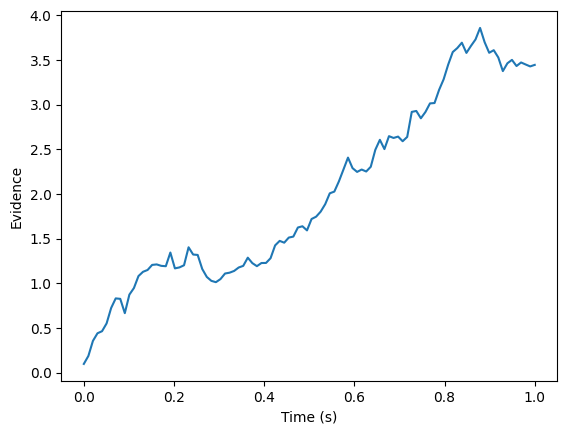

In [2]:
def evidence_accumulation(nu, max_t, dt):
    timesteps = int(max_t / dt)
    t = np.linspace(0, max_t, timesteps)

    noise = np.random.normal(0, 1, size=timesteps) * np.sqrt(dt)
    evidence = nu * t + np.cumsum(noise)

    return t, evidence

t, evidence = evidence_accumulation(nu=2.5, max_t=1.0, dt=0.01)

plt.plot(t, evidence)
plt.xlabel("Time (s)")
plt.ylabel("Evidence")

## Simple response time (Wald model)

Here we will train a simple response time model based on a single
accumulator that diffuses with a drift $\nu$ to a decision threshold
$\alpha$. For more background about the Wald model, see Anders, Alario,
& van Maanen (2016). Here we will estimate only the drift and decision
threshold, no non-decision time or variability in starting point. In
this case, the mean and a standard deviation of the response times are
sufficient statistics, so we do not need a summary network.

In [3]:
def prior():
    # drift rate
    nu=np.random.gamma(shape=10, scale=0.25)
    # decision threshold
    alpha=np.random.gamma(shape=10, scale=0.1)

    return dict(nu=nu, alpha=alpha)

# generate data for a single trial
def trial(nu, alpha, max_t, dt):
    t, evidence = evidence_accumulation(nu, max_t, dt)
    passage = np.argmax(evidence > alpha)
    rt = max_t if passage==0 else t[passage]

    return rt

# generate data for n trials
def likelihood(nu, alpha, n=250, max_t=3.0, dt=0.02):
    rt = np.zeros(n)
    for i in range(n):
        rt[i] = trial(nu, alpha, max_t, dt)

    return dict(rt=rt)

# sufficient statistics: mean, sd, n
def summary(rt):
    return dict(
        mean = np.mean(rt),
        sd = np.std(rt)
    )

simulator = bf.make_simulator([prior, likelihood, summary])

In [4]:
df = simulator.sample(1_000)

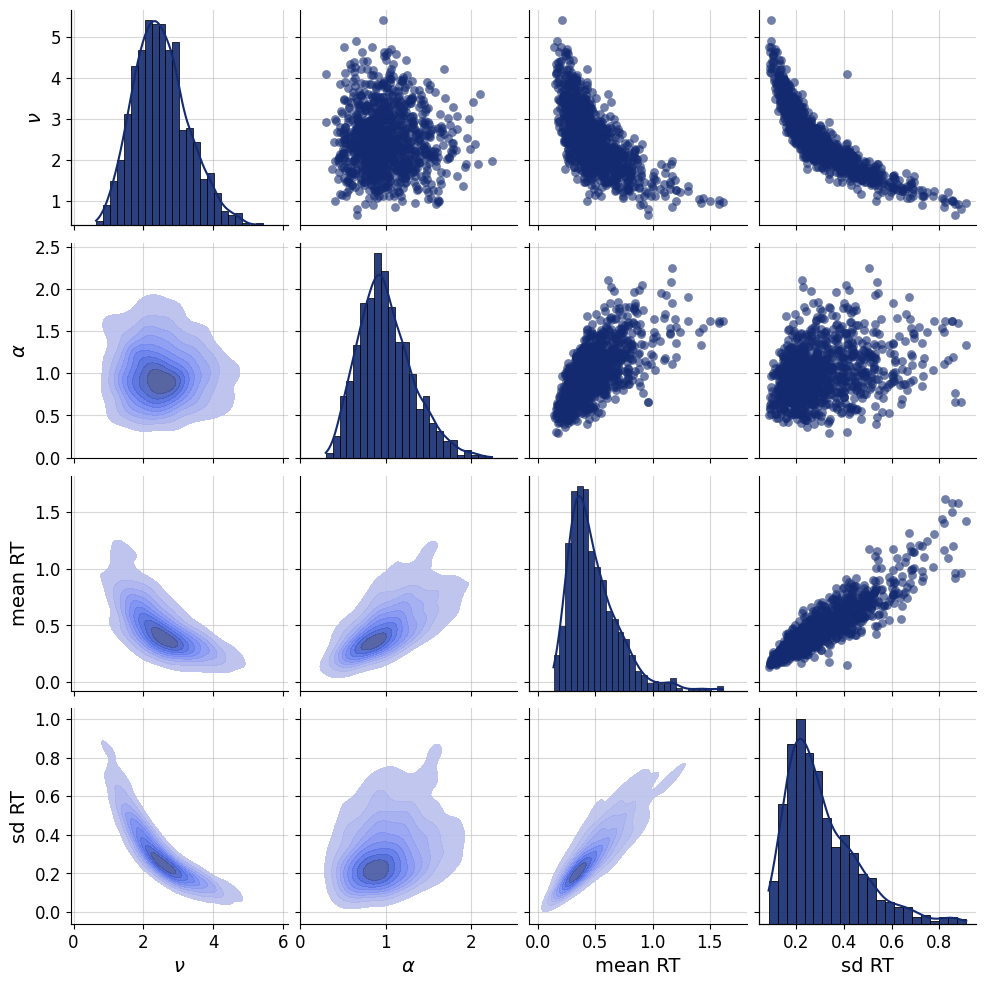

In [5]:
f=bf.diagnostics.pairs_samples(
    df, 
    variable_keys=["nu", "alpha", "mean", "sd"],
    variable_names=[r"$\nu$", r"$\alpha$", "mean RT", "sd RT"])

In [6]:
adapter = (bf.Adapter()
    .constrain(["nu", "alpha"], lower=0)
    .concatenate(["nu", "alpha"], into="inference_variables")
    .concatenate(["mean", "sd"], into="inference_conditions")
    .drop("rt")
)

In [7]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    inference_network = bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),
    inference_variables = ["nu", "alpha"],
    inference_conditions = ["mean", "sd"]
)

In [8]:
train_data = simulator.sample(5_000)
validation_data = simulator.sample(1_000)

In [9]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=50, 
    batch_size=250, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.3237 - loss/inference_loss: 4.3237 - val_loss: 3.2620 - val_loss/inference_loss: 3.2620
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9751 - loss/inference_loss: 2.9751 - val_loss: 2.6640 - val_loss/inference_loss: 2.6640
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5618 - loss/inference_loss: 2.5618 - val_loss: 2.4644 - val_loss/inference_loss: 2.4644
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3460 - loss/inference_loss: 2.3460 - val_loss: 2.2887 - val_loss/inference_loss: 2.2887
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1960 - loss/inference_loss: 2.1960 - val_loss: 2.0773 - val_loss/inference_loss: 2.0773
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0349 - loss/inference_loss: 2.0349 - val_loss: 1.9428 - val_loss/inference_loss: 1.9428
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8103 - loss/inference_loss: 1.8103 - val_loss: 

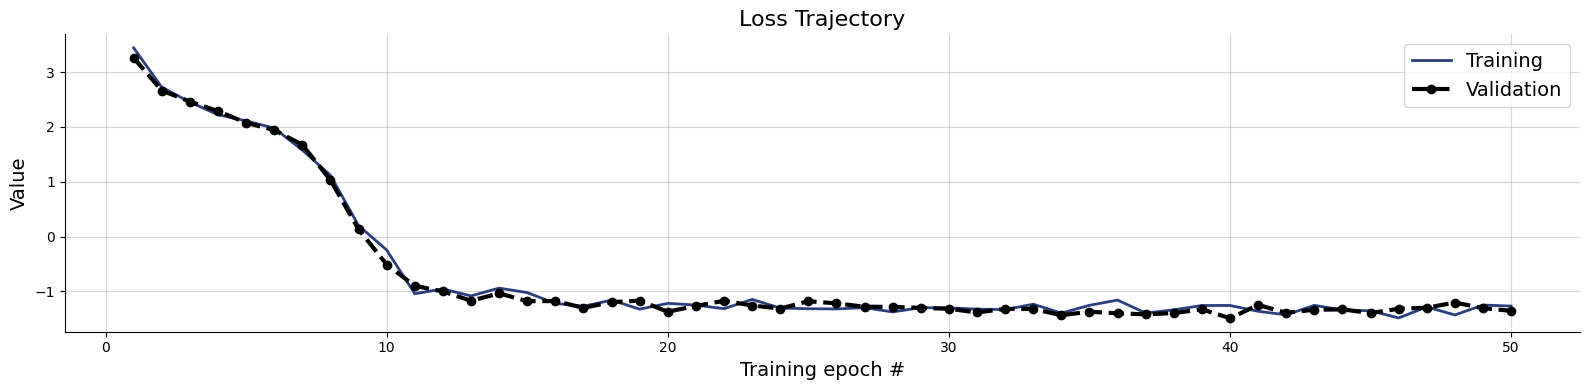

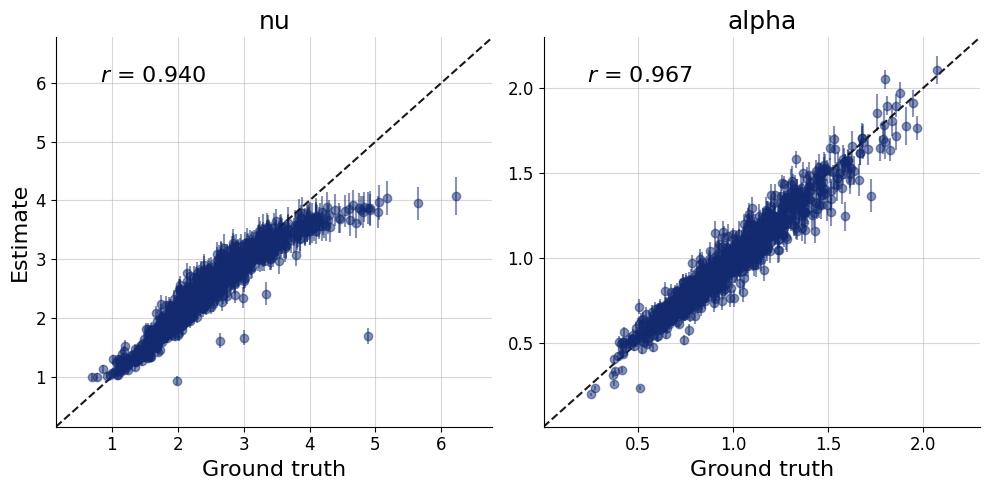

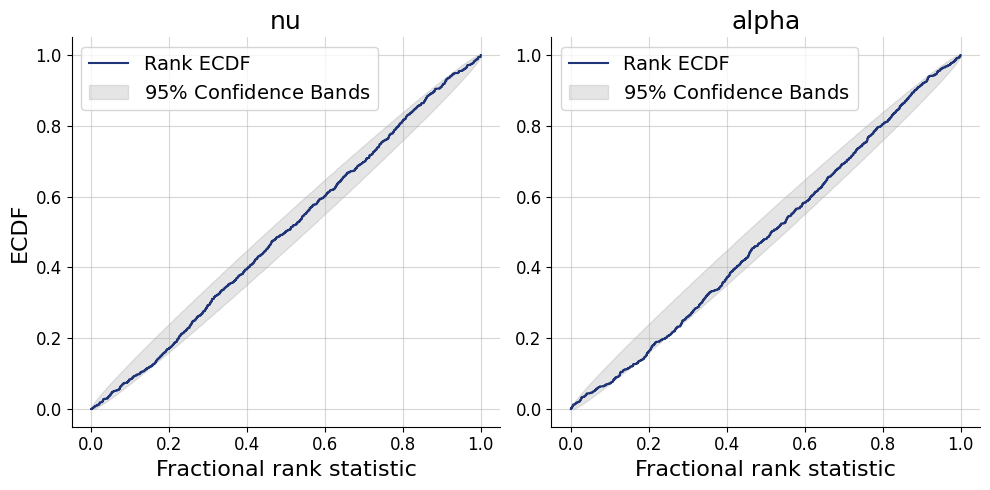

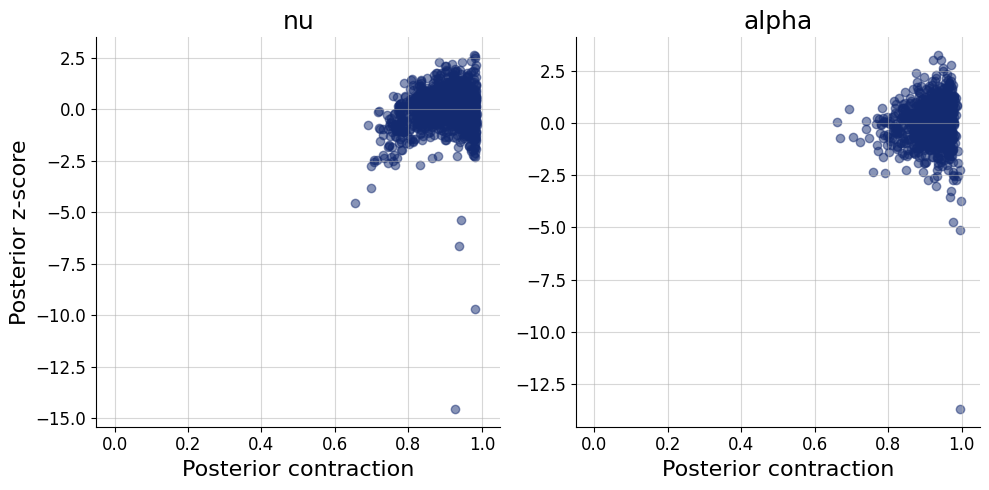

In [10]:
test_data = simulator.sample(1_000)
plots=workflow.plot_default_diagnostics(test_data=test_data)

## Two choice task (Racing diffusion model)

We’ll assume a simple RDM with two choice alternatives (Tillman et al.,
2020).

Here we will simplify the model to include no bias, no variability in
starting points. Instead of modeling one accumulator for each of \[left,
right\] responses, we will simply model one accumulator for “incorrect”
and one accumulator for “correct” response. This makes it a bit easier
to simulate from (we do not need to simulate stimuli).

The model has four parameters: 2 drift rates (incorrect - $\nu_0$,
correct $\nu_1$), decision threshold $\alpha$, and non-decision time
$\tau$.

In [11]:
def context(n=None):
    if n is None:
        n = np.random.randint(200, 351)
    return dict(n=n)

def prior(nu=None, alpha=None, tau=None):
    if nu is None:
        nu=np.random.dirichlet([2, 2])
        nu=np.random.gamma(shape=5, scale=0.5) * nu
    if alpha is None:
        alpha=np.random.gamma(shape=5, scale=0.2)
    if tau is None:
        tau=np.random.exponential(0.15)
    else:
        tau=tau.item()

    return dict(nu=nu, alpha=alpha, tau=tau)

# generate data for a single trial
def trial(nu, alpha, tau, max_t, dt):
    response = -1
    min_t = max_t
    # loop over accumulators
    # if an accumulator has a smaller passage time than the current minimum
    # save it as the fastest accumulator (response)
    for resp, drift in enumerate(nu):
        t, evidence = evidence_accumulation(drift, max_t, dt)
        passage = np.argmax(evidence > alpha)
        t = max_t if passage==0 else t[passage]
        
        if t < min_t:
            min_t = t
            response = resp
            
    return min_t+tau, response

# generate data for n trials
# keep the data.shape always to max_n
# the rest is filled with 0s
def likelihood(n, nu, alpha, tau, max_t=3.0, dt=0.02, max_n=350):
    rt = np.zeros(max_n)
    response = np.zeros(max_n)
    observed = np.zeros(max_n)
    for i in range(n):
        result = trial(nu, alpha, tau, max_t, dt)
        rt[i] = result[0]
        response[i] = result[1]
        observed[i] = 1

    return dict(rt=rt, response=response, observed=observed)

simulator = bf.make_simulator([context, prior, likelihood])

In [12]:
adapter = (bf.Adapter()
    .as_set(["rt", "response", "observed"])
    .constrain(["nu", "alpha", "tau"], lower=0)
    .standardize(include="nu",    mean= 0.7, std=1.2)
    .standardize(include="alpha", mean= 0.5, std=0.7)
    .standardize(include="tau",   mean=-2.5, std=1.3)
    .concatenate(["nu", "alpha", "tau"], into="inference_variables")
    .concatenate(["rt", "response", "observed"], into="summary_variables")
    .rename("n", "inference_conditions")
)

In [13]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    inference_network = bf.networks.CouplingFlow(
        permutation="swap", 
        subnet_kwargs=dict(dropout=False)
    ),
    summary_network=bf.networks.DeepSet(
        base_distribution="normal",
        dropout=False
    ),
    inference_variables = ["nu", "alpha", "tau"],
    inference_conditions = ["n"],
    summary_variables = ["rt", "response", "observed"]
)

In [14]:
train_data = simulator.sample(5_000)
validation_data = simulator.sample(1_000)

In [15]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=100, 
    batch_size=250, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 14.3609 - loss/inference_loss: 14.0609 - loss/summary_loss: 0.3000 - val_loss: 6.1114 - val_loss/inference_loss: 5.9787 - val_loss/summary_loss: 0.1327
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step - loss: 5.8206 - loss/inference_loss: 5.6786 - loss/summary_loss: 0.1419 - val_loss: 5.5208 - val_loss/inference_loss: 5.3216 - val_loss/summary_loss: 0.1992
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 645ms/step - loss: 5.2590 - loss/inference_loss: 5.0502 - loss/summary_loss: 0.2088 - val_loss: 5.1275 - val_loss/inference_loss: 4.9059 - val_loss/summary_loss: 0.2216
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - loss: 4.7636 - loss/inference_loss: 4.5833 - loss/summary_loss: 0.1803 - val_loss: 4.5547 - val_loss/inference_loss: 4.4057 - val_loss/summary_loss: 0.1490
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 607ms/step - loss: 4.4397 - loss/inference_loss: 4.2925 - loss/summary_loss: 0.1471 - val_loss: 4.3656 - val_l

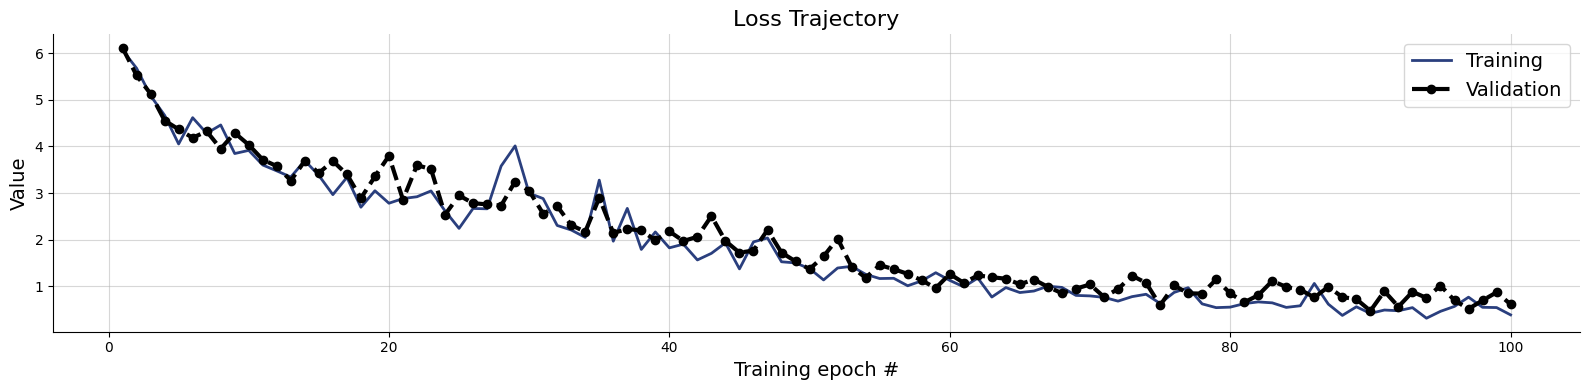

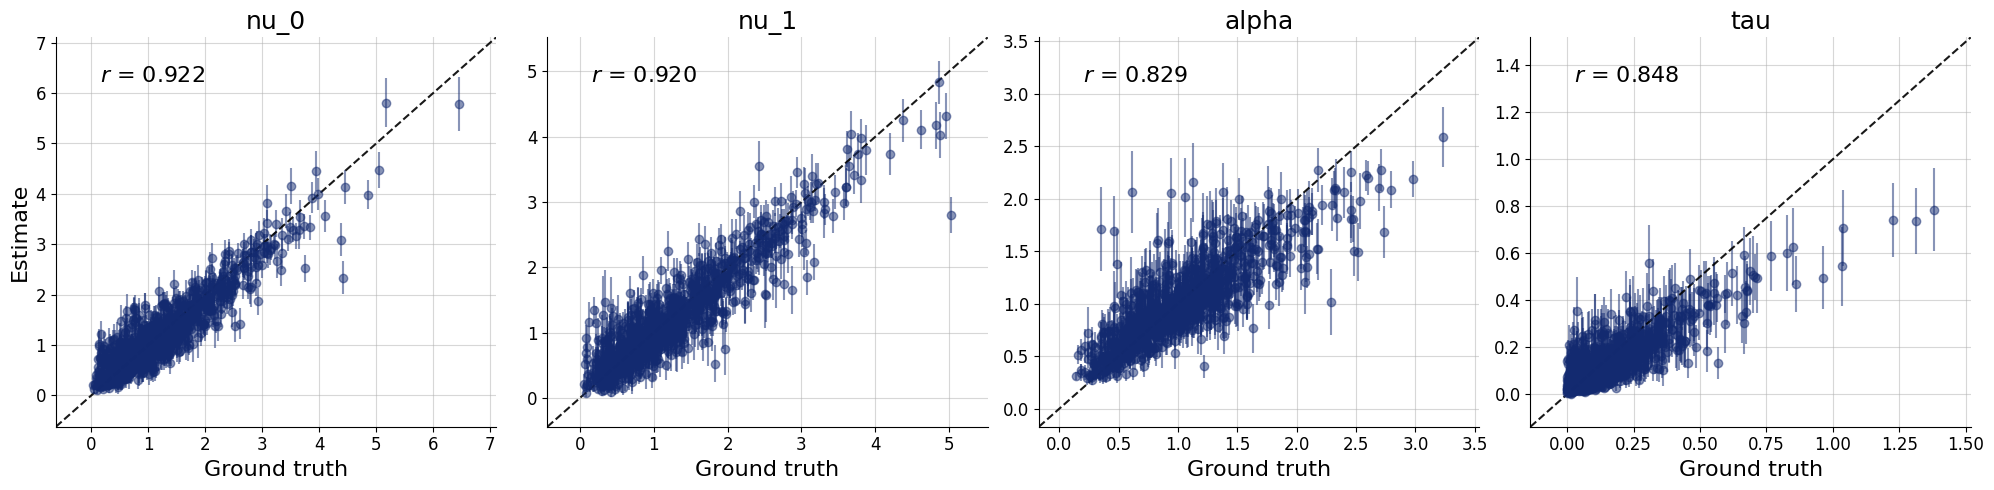

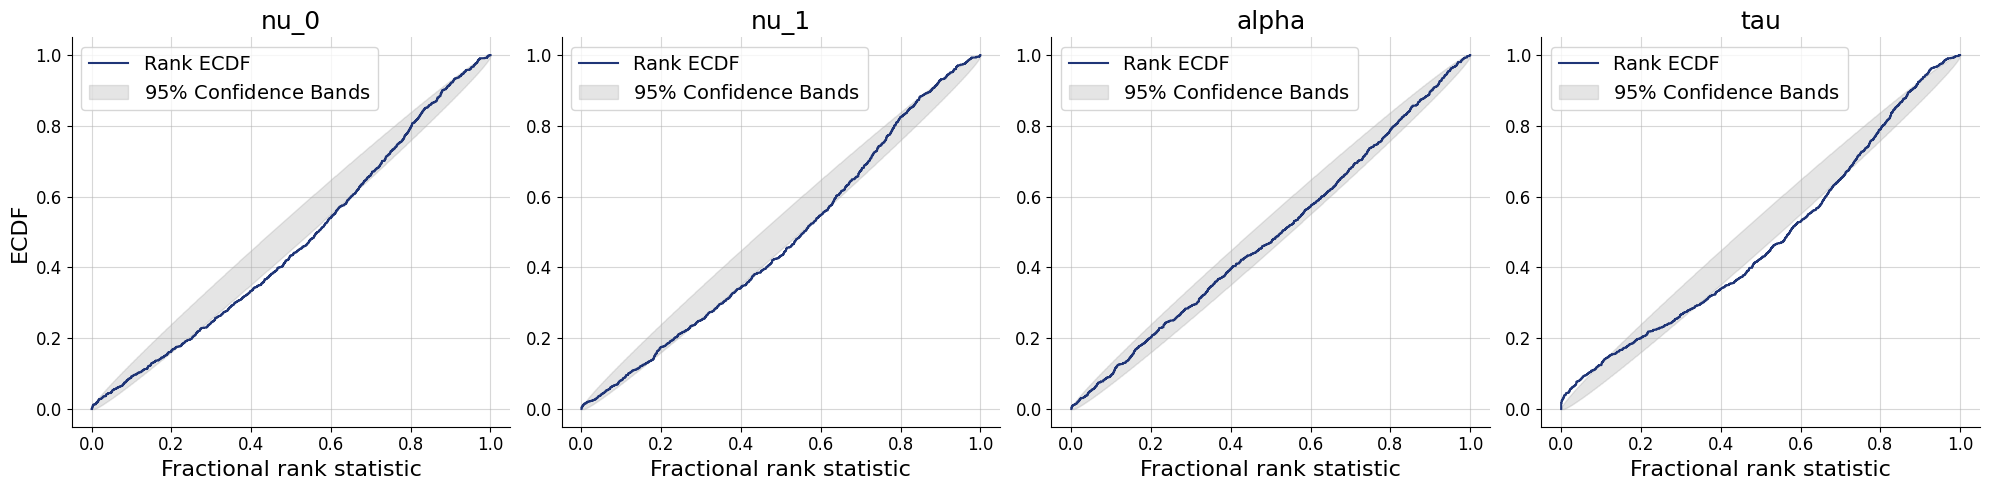

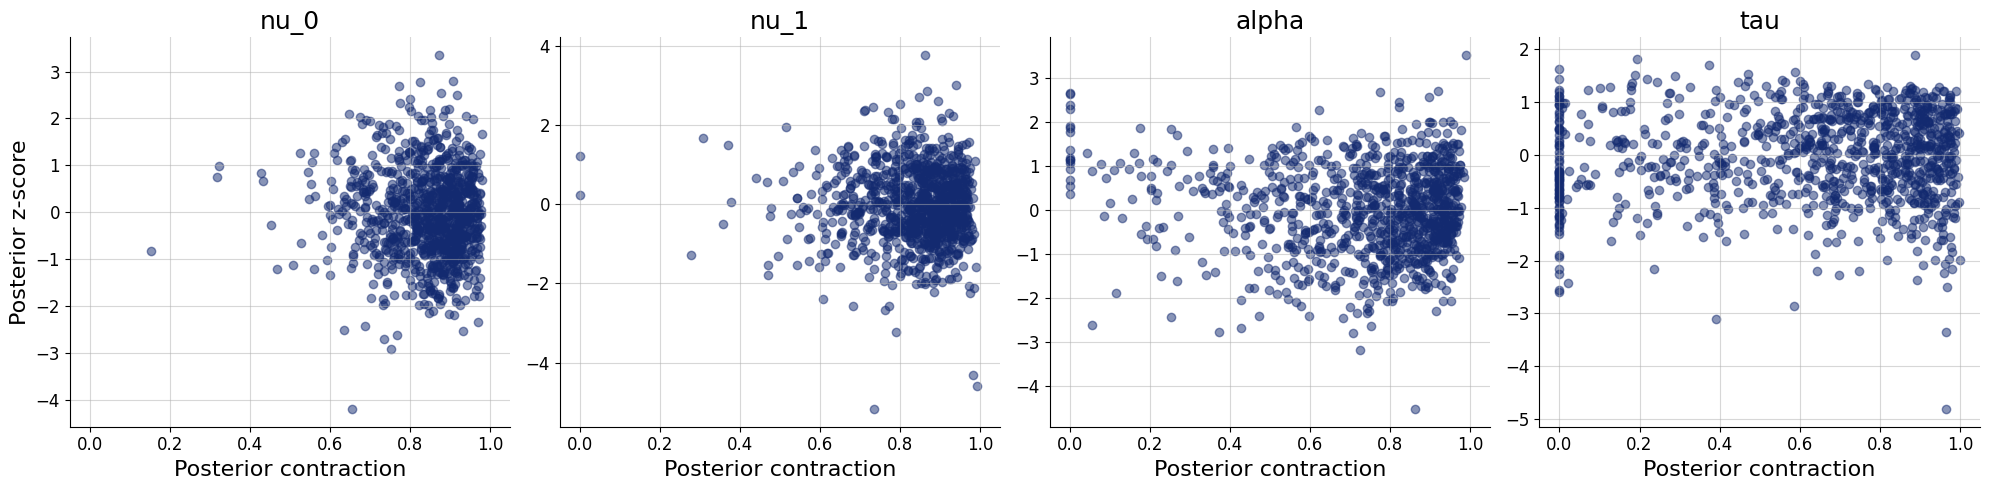

In [16]:
test_data = simulator.sample(1_000)
plots=workflow.plot_default_diagnostics(test_data=test_data)

### Application to real data

Here we will work with data from Fortmann, et al. (2008), that is also
included in the R package `EMC2` (Stevenson, Donzallaz, & Heathcote,
2025). Here we use a slightly reshaped dataset where each combination of
subject x condition is extended to a length of 350 trials (the missing
trials are filled with 0s). This allows us to estimate the posterior for
each subject in each condition with a single pass through the posterior
approximator.

In [17]:
data_inference = pd.read_csv("forstmann.csv")

In [18]:
data_inference['condition'].unique()

array(['accuracy', 'speed', 'neutral'], dtype=object)

In [19]:
data_inference_grouped = data_inference.groupby(["subject", "condition"])

In [20]:
data_inference_dict = {
    key: np.array([group[key].values.reshape(350, 1) for _, group in data_inference_grouped]) 
             for key in ['rt', 'response', 'observed']}
data_inference_dict["n"] = np.sum(data_inference_dict["observed"], axis=1)
print({key: value.shape for key, value in data_inference_dict.items()})

{'rt': (57, 350, 1), 'response': (57, 350, 1), 'observed': (57, 350, 1), 'n': (57, 1)}

In [21]:
posterior_samples = workflow.sample(conditions=data_inference_dict, num_samples=1_000)

In [22]:
# pick the first participant, first condition
posterior = {key: value[0] for key, value in posterior_samples.items()}
data = data_inference_grouped.get_group(('as1t', 'accuracy'))

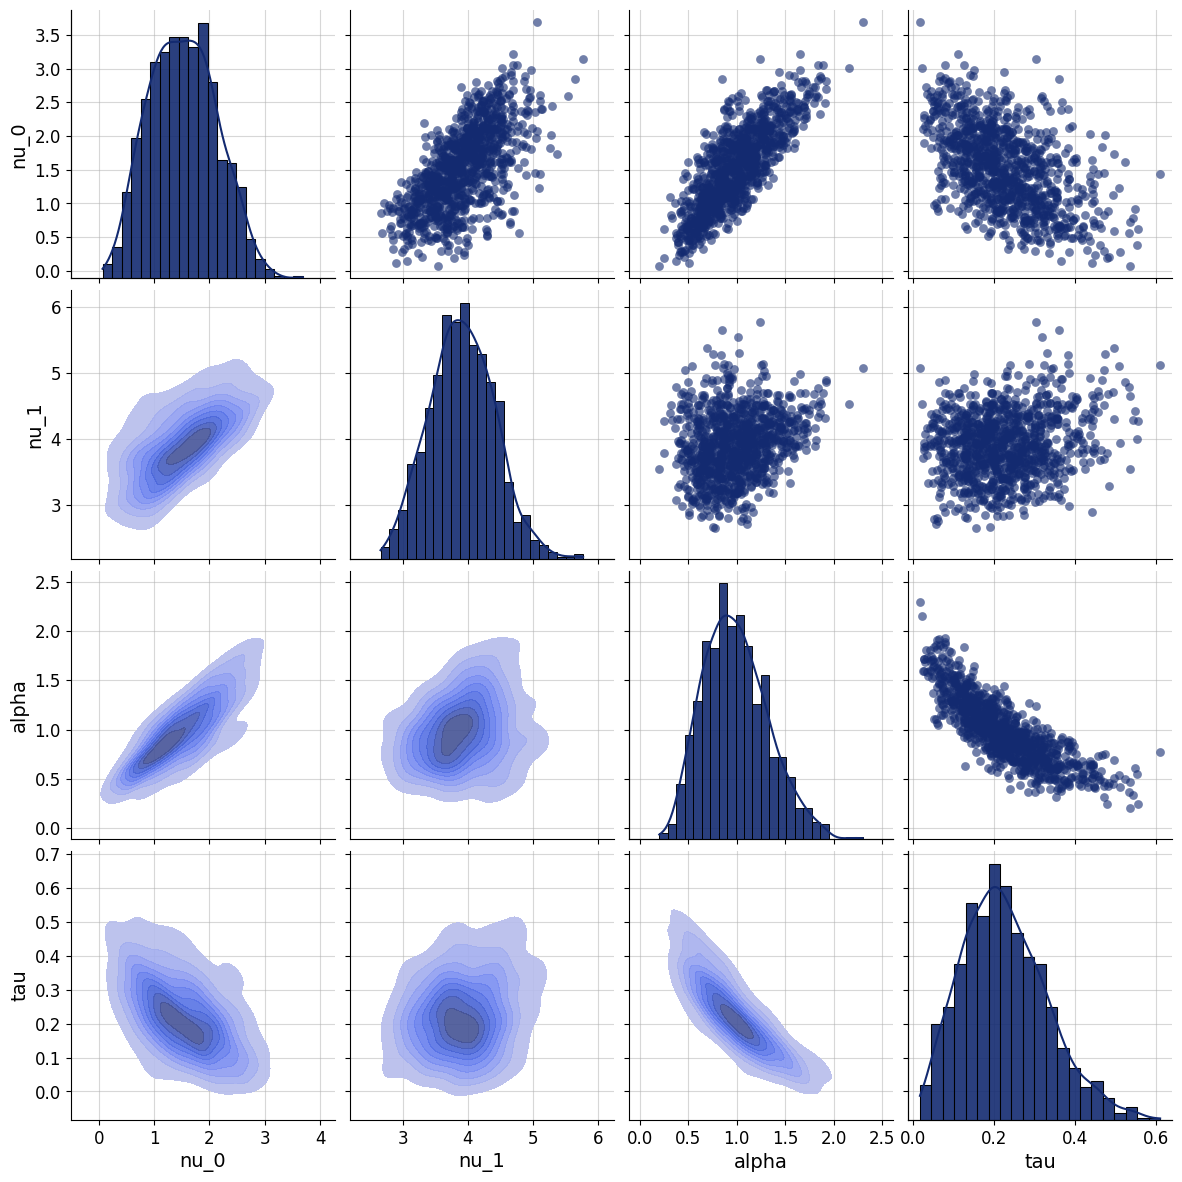

In [23]:
f=bf.diagnostics.pairs_posterior(estimates=posterior)

In [24]:
def ecdf(rt, response, observed, **kwargs):
    observed_mask = (observed == 1)
    response_0_mask = ((response == 0) & observed_mask)
    response_1_mask = ((response == 1) & observed_mask)

    response_0_prop = np.sum(response_0_mask) / np.sum(observed_mask)
    response_1_prop = np.sum(response_1_mask) / np.sum(observed_mask)

    response_0_ecdf = stats.ecdf(rt[response_0_mask]).cdf
    response_0_ecdf = response_0_prop * response_0_ecdf.evaluate(np.linspace(0, 1, 101))

    response_1_ecdf = stats.ecdf(rt[response_1_mask]).cdf
    response_1_ecdf = response_1_prop * response_1_ecdf.evaluate(np.linspace(0, 1, 101))

    return response_0_ecdf, response_1_ecdf
    

In [25]:
plot_data = ecdf(**data)

In [26]:
posterior_predictives = simulator.sample(1000, **posterior)

In [27]:
plot_data_predictive = []
for i in range(1000):
    x = { key: value[i:i+1,...] for key, value in posterior_predictives.items()}
    plot_data_predictive.append(ecdf(**x))
plot_data_predictive = np.array(plot_data_predictive)

In [28]:
plot_data_quantiles = np.quantile(
    plot_data_predictive, 
    q = [0.25, 0.5, 0.75],
    axis=0
)
plot_data_quantiles.shape

(3, 2, 101)

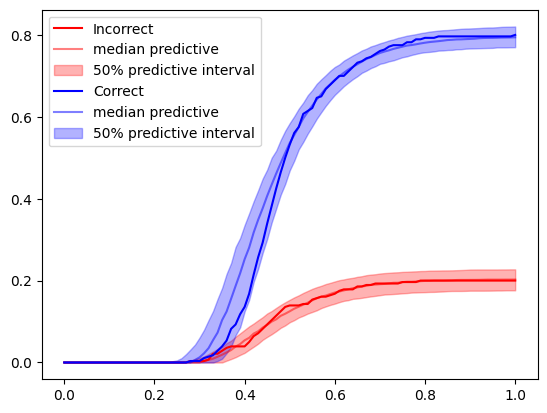

In [29]:
t = np.linspace(0, 1, 101)
cols = ["red", "blue"]
for i, lab in enumerate(["Incorrect", "Correct"]):
    plt.plot(t, plot_data[i], label=lab, color=cols[i])
    plt.plot(t, plot_data_quantiles[1, i, :], color=cols[i], alpha=0.5, label="median predictive")
    plt.fill_between(
        t,
        plot_data_quantiles[0,  i,:],
        plot_data_quantiles[-1, i,:],
        label="50% predictive interval",
        color=cols[i],
        alpha=0.3
    )
f=plt.legend()

# Further exercises

1.  The diagnostics show that there are some situations where we learn
    basically nothing from the data. Find out whether there is some
    common pattern between these simulations and whether you could fix
    this.
2.  Each participant in the experiment was exposed to three different
    conditions (speed, neutral, accuracy). Here we fitted a simple model
    to each condition separately. However, it would make much more sense
    to fit a single model that encompassess all three conditions. Think
    about which parameters of the decision making model should
    theoretically be affected by the experimental condition, and
    implement a model that quantifies these differences.
3.  The data we worked with here are recoded such that we only have
    correct vs incorrect responses. However, the actual data contain two
    columns, where the stimulus has values “left” vs “right” and the
    response as well, “left” or “right”. Think about how to
    reparametrize the model such that instead of having one accumulator
    for correct and one for incorrect responses, you would have one
    accumulator for “left” and one accumulator “right” – and how would
    you make sure that the model responds to changes in stimulus. Train
    a BayesFlow model based on data from such simulator.
4.  The function that simulates the evidence accumulation process
    (`evidence_accumulation`) generates a standard Wiener diffusion with
    drift. Look for alternative ways how you could represent this
    process and try to implement it in a statistical model (examples:
    linear accumulation, Ornstein-Uhlenbeck process, Levy flight, …).

## References

Anders, R., Alario, F., & Van Maanen, L. (2016). The shifted Wald
distribution for response time data analysis. *Psychological methods,
21*(3), 309.

Forstmann, B. U., Dutilh, G., Brown, S., Neumann, J., Von Cramon, D. Y.,
Ridderinkhof, K. R., & Wagenmakers, E. J. (2008). Striatum and pre-SMA
facilitate decision-making under time pressure. *Proceedings of the
National Academy of Sciences, 105*(45), 17538-17542.

Stevenson N., Donzallaz M., Heathcote A. (2025). EMC2: Bayesian
Hierarchical Analysis of Cognitive Models of Choice. R package version
3.1.0, https://github.com/ampl-psych/emc2.

Tillman, G., Van Zandt, T., & Logan, G. D. (2020). Sequential sampling
models without random between-trial variability: The racing diffusion
model of speeded decision making. *Psychonomic Bulletin & Review,
27*(5), 911-936.